# Multidimensional Data Workshop - Unidata 2023

This session will cover how to perform an exploratory data analysis on multidimensional datasets, such as netCDF, using Jupyter Notebooks. We will use the xarray Python package to examine metadata, calculate simple statistics, and quickly preview array-based data.

By Jon Thielen, Colorado State University, thielen@rams.colostate.edu

---

## Step 0: Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Step 1: Load and Inspect Dataset

By default, we will be using an example subset of GFS data from Hurricane Irma (September 5th, 2017) included in MetPy’s test suite ([see also: the xarray with MetPy tutorial in MetPy's docs](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html)). However, very little of what follows will be dataset-specific, so a few alternate dataset suggestions are including in case you would like to try something different. Or, if you have a particularly interesting remote dataset of multidimensional data you would like to explore, feel free to substitute that!

In [2]:
data = xr.open_dataset("irma_gfs_example.nc")

# Alternate: ROMS example from xarray
# data = xr.tutorial.open_dataset("ROMS_example")

# Alternate: A recent 1 degree GFS forecast
# data = xr.open_dataset("https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_20230605_0000.grib2")

# Alternate: A sample of NARR data from NCAR RDA
# data = xr.open_dataset("https://rda.ucar.edu/thredds/dodsC/files/g/ds608.0/3HRLY/2013/NARR3D_201309_1012.tar")

In [3]:
# In JupyterLab, an HTML representation can be simply displayed
# by simply exposing the dataset variable
data

<xarray.Dataset>
Dimensions:                              (time1: 9, latitude: 81,
                                          isobaric3: 31, isobaric1: 21,
                                          longitude: 131)
Coordinates:
  * time1                                (time1) datetime64[ns] 2017-09-05T12...
    reftime                              datetime64[ns] ...
  * latitude                             (latitude) float32 50.0 49.5 ... 10.0
  * isobaric3                            (isobaric3) float64 100.0 ... 1e+05
  * isobaric1                            (isobaric1) float64 1e+04 ... 1e+05
  * longitude                            (longitude) float32 250.0 ... 315.0
Data variables:
    Vertical_velocity_pressure_isobaric  (time1, isobaric1, latitude, longitude) float32 ...
    Relative_humidity_isobaric           (time1, isobaric3, latitude, longitude) float32 ...
    Temperature_isobaric                 (time1, isobaric3, latitude, longitude) float32 ...
    u-component_of_wind_isobaric         (time1, isobaric3, latitude, longitude) float32 ...
    v-component_of_wind_isobaric         (time1, isobaric3, latitude, longitude) float32 ...
    Geopotential_height_isobaric         (time1, isobaric3, latitude, longitude) float32 ...
    LatLon_361X720-0p25S-180p00E         int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

Notice how we can see much more metadata than we could with tabular data. This is by design. The NetCDF data model was designed to be “self-describing”, allowing a user to very easily see critical information about the dataset and individual variables.

> Question: What information for EDA can we glean from just this preview?

### Aside: Metadata Conventions

Notice that (at least for most of the example datasets included above) we have info in the global metadata called Conventions. While not crucial to us right now (they'll become more important for some later sessions this workshop!), these will be important for future analyses you do, so let’s briefly discuss.

Consider the following, you are working with several datasets from various sources and comparing variables in one region to another. Imagine comparing temperatures from three different datasets, but the labels for temperature are different. One is “T”, one is “temp”, and one is “temperature”. Additionally, two of the datasets record temperature in K and one records temperature in degrees C. Reproducing results on these datasets would be cumbersome because you would have to keep changing variable names, units, and potentially other attributes. 

From [the CF website](https://cfconventions.org/):
“The Climate and Forecast metadata conventions (CF) are a community-developed standard designed to promote the processing and sharing of climate and forecast model and observational output data, and derived data products. The conventions define metadata that provide a definitive description of what the data in each variable represents, and the spatial and temporal properties of the data. This enables users of data from different sources to decide which quantities are comparable, and facilitates building applications with powerful extraction, regridding, and display capabilities. The CF convention includes a standard name table, which defines strings that identify physical quantities.”

## Step 2: Initial Data Quality Checks

A good first step in exploring a dataset is characterizing the missing values, if any. Let's choose a single data variable to investigate:

In [4]:
datavar = data["Temperature_isobaric"]
datavar

<xarray.DataArray 'Temperature_isobaric' (time1: 9, isobaric3: 31,
                                          latitude: 81, longitude: 131)>
[2960469 values with dtype=float32]
Coordinates:
  * time1      (time1) datetime64[ns] 2017-09-05T12:00:00 ... 2017-09-06T12:0...
    reftime    datetime64[ns] ...
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 11.5 11.0 10.5 10.0
  * isobaric3  (isobaric3) float64 100.0 200.0 300.0 ... 9.5e+04 9.75e+04 1e+05
  * longitude  (longitude) float32 250.0 250.5 251.0 251.5 ... 314.0 314.5 315.0
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast
    grid_mapping:                   LatLon_361X720-0p25S-180p00E

What happens if we try an `isnull` check like we might in pandas?

In [5]:
datavar.isnull()

<xarray.DataArray 'Temperature_isobaric' (time1: 9, isobaric3: 31,
                                          latitude: 81, longitude: 131)>
array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
...
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]])
Coordinates:
  * time1      (time1) datetime64[ns] 2017-09-05T12:00:00 ... 2017-09-06T12:0...
    reftime    datetime64[ns] ...
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 11.5 11.0 10.5 10.0
  * isobaric3  (isobaric3) float64 100.0 200.0 300.0 ... 9.5e+04 9.75e+04 1e+05
  * longitude  (longitude) float32 250.0 250.5 251.0 251.5 ... 314.0 314.5 315.0

Indeed, this is a multidimensional dataset, and the limited "corners" of the (in this case) 4D array don't tell us much. Maybe if tried to "count" the total number of missing values?

In [6]:
datavar.isnull().sum()

<xarray.DataArray 'Temperature_isobaric' ()>
array(0)
Coordinates:
    reftime  datetime64[ns] ...

In the Irma GFS example, there are no missing temperature values! (Prehaps, if you are using an alternate dataset, you may encounter some.)

Also note how we used `.sum()` to compute a sum across the entire data variable. These kind of aggregation methods are frequently used with xarray, and will be covered a bit more later on.

Now, we may want to see if the range/distribution of values is reasonable, by means of a histogram. A quick way of doing so is as follows:

(array([ 66980., 267107., 375055., 358252., 313477., 400564., 299316.,
        435851., 431209.,  12658.]),
 array([190.29998779, 202.8099823 , 215.31997681, 227.82998657,
        240.33998108, 252.84997559, 265.35998535, 277.8699646 ,
        290.37997437, 302.88995361, 315.39996338]),
 <BarContainer object of 10 artists>)

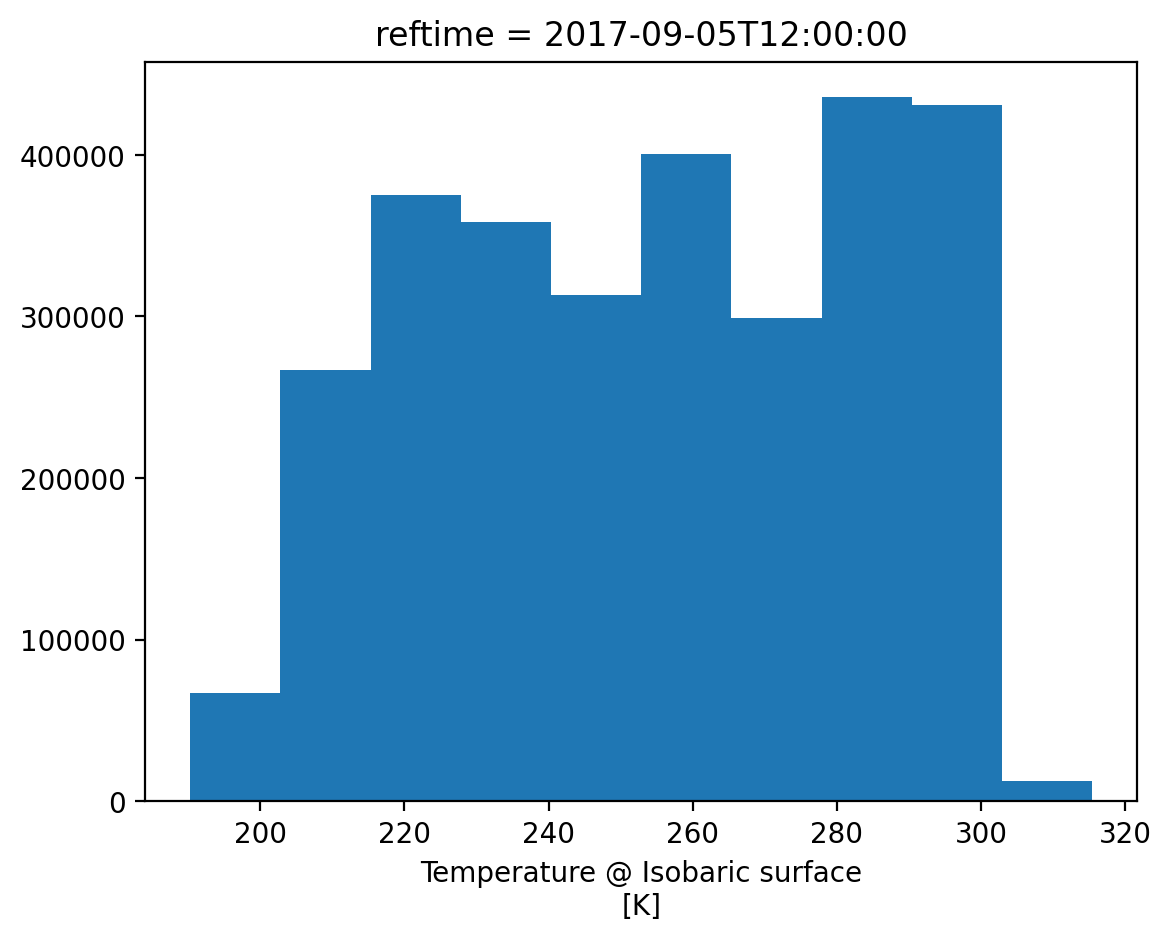

In [7]:
datavar.plot.hist()

## Step 3: Plotting Multidimensional Data for Exploration (with Selection/Subsetting)

Perhaps we actually want to see something map-like for our data, as an *image*, rather than a chart summarizing the full set of values. However, we (most likely) have more than two dimensions! So, first, let's see how to select a subset of our data along certain *dimesnion coordinates* (corresponding to *indexes*).

> From [xarray terminology](https://docs.xarray.dev/en/stable/user-guide/terminology.html): A one-dimensional coordinate array assigned to `arr` with both a name and dimension name in `arr.dims`. Dimension coordinates are used for label-based indexing and alignment, like the index found on a `pandas.DataFrame` or `pandas.Series`. In fact, dimension coordinates use `pandas.Index` objects under the hood for efficient computation. Dimension coordinates are marked by `*` when printing a DataArray or Dataset.

In [8]:
# Try NumPy-style indexing first
datavar_sample = datavar[0, :, :, :]
datavar_sample

<xarray.DataArray 'Temperature_isobaric' (isobaric3: 31, latitude: 81,
                                          longitude: 131)>
array([[[258. , 258. , ..., 258.2, 258.3],
        [257.9, 257.9, ..., 258.2, 258.2],
        ...,
        [261. , 261. , ..., 258.1, 258.2],
        [261.2, 261.2, ..., 258.2, 258.3]],

       [[256.5, 256.5, ..., 255.6, 255.5],
        [256.4, 256.4, ..., 255.5, 255.5],
        ...,
        [259.2, 259.2, ..., 261.4, 261.6],
        [259.4, 259.3, ..., 261.4, 261.6]],

       ...,

       [[288.8, 288.3, ..., 285. , 284.9],
        [288.3, 288.3, ..., 284.8, 284.6],
        ...,
        [297.1, 297.1, ..., 297.4, 297.6],
        [297. , 296.8, ..., 297.4, 297.2]],

       [[290.2, 289.7, ..., 286.6, 286.7],
        [289.7, 289.7, ..., 286.2, 286.1],
        ...,
        [299.2, 299.2, ..., 299.5, 299.7],
        [299.2, 298.9, ..., 299.5, 299.3]]], dtype=float32)
Coordinates:
    time1      datetime64[ns] 2017-09-05T12:00:00
    reftime    datetime64[ns] 2017-09-05T12:00:00
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 11.5 11.0 10.5 10.0
  * isobaric3  (isobaric3) float64 100.0 200.0 300.0 ... 9.5e+04 9.75e+04 1e+05
  * longitude  (longitude) float32 250.0 250.5 251.0 251.5 ... 314.0 314.5 315.0
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast
    grid_mapping:                   LatLon_361X720-0p25S-180p00E

Note that this collapsed the first dimension (by selecting the initial item). Now, (in the Irma example), this corresponded to the first time, so we can process to also select the "surface" as the bottom (last) vertical level. 

In [9]:
sfctemp0 = datavar[0, -1]  # note that trailing dimensions are inferred
sfctemp0

<xarray.DataArray 'Temperature_isobaric' (latitude: 81, longitude: 131)>
array([[290.2, 289.7, 289.2, ..., 286.6, 286.6, 286.7],
       [289.7, 289.7, 289.6, ..., 286.5, 286.2, 286.1],
       [289.6, 289.4, 289.6, ..., 286.2, 286. , 286. ],
       ...,
       [299.5, 299.5, 299.4, ..., 299.9, 300. , 300.1],
       [299.2, 299.2, 299.1, ..., 299.9, 299.5, 299.7],
       [299.2, 298.9, 298.8, ..., 299.9, 299.5, 299.3]], dtype=float32)
Coordinates:
    time1      datetime64[ns] 2017-09-05T12:00:00
    reftime    datetime64[ns] 2017-09-05T12:00:00
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 11.5 11.0 10.5 10.0
    isobaric3  float64 1e+05
  * longitude  (longitude) float32 250.0 250.5 251.0 251.5 ... 314.0 314.5 315.0
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast
    grid_mapping:                   LatLon_361X720-0p25S-180p00E

However, this "position-based" indexing fails to leverage the coordinate information that makes NetCDF and xarray so great! Instead, what if we wanted to select based on a "label", i.e., a particular coordinate value?

In [10]:
temperature_selection = datavar.sel(time1='2017-09-05T12:00')
temperature_selection

<xarray.DataArray 'Temperature_isobaric' (isobaric3: 31, latitude: 81,
                                          longitude: 131)>
array([[[258. , 258. , ..., 258.2, 258.3],
        [257.9, 257.9, ..., 258.2, 258.2],
        ...,
        [261. , 261. , ..., 258.1, 258.2],
        [261.2, 261.2, ..., 258.2, 258.3]],

       [[256.5, 256.5, ..., 255.6, 255.5],
        [256.4, 256.4, ..., 255.5, 255.5],
        ...,
        [259.2, 259.2, ..., 261.4, 261.6],
        [259.4, 259.3, ..., 261.4, 261.6]],

       ...,

       [[288.8, 288.3, ..., 285. , 284.9],
        [288.3, 288.3, ..., 284.8, 284.6],
        ...,
        [297.1, 297.1, ..., 297.4, 297.6],
        [297. , 296.8, ..., 297.4, 297.2]],

       [[290.2, 289.7, ..., 286.6, 286.7],
        [289.7, 289.7, ..., 286.2, 286.1],
        ...,
        [299.2, 299.2, ..., 299.5, 299.7],
        [299.2, 298.9, ..., 299.5, 299.3]]], dtype=float32)
Coordinates:
    time1      datetime64[ns] 2017-09-05T12:00:00
    reftime    datetime64[ns] 2017-09-05T12:00:00
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 11.5 11.0 10.5 10.0
  * isobaric3  (isobaric3) float64 100.0 200.0 300.0 ... 9.5e+04 9.75e+04 1e+05
  * longitude  (longitude) float32 250.0 250.5 251.0 251.5 ... 314.0 314.5 315.0
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast
    grid_mapping:                   LatLon_361X720-0p25S-180p00E

In [11]:
# or multiple at once!
temperature_selection = datavar.sel(time1='2017-09-05T12:00', isobaric3=50000)
temperature_selection

<xarray.DataArray 'Temperature_isobaric' (latitude: 81, longitude: 131)>
array([[266.69025, 266.49023, 266.19025, ..., 262.99023, 262.99023, 262.99023],
       [266.79022, 266.69025, 266.49023, ..., 263.69025, 263.59024, 263.59024],
       [266.89023, 266.89023, 266.59024, ..., 264.19025, 264.09024, 263.99023],
       ...,
       [267.99023, 268.09024, 267.79022, ..., 267.69025, 267.49023, 267.49023],
       [267.89023, 267.89023, 267.59024, ..., 267.79022, 267.59024, 267.69025],
       [267.69025, 267.39023, 267.49023, ..., 267.59024, 267.59024, 267.69025]],
      dtype=float32)
Coordinates:
    time1      datetime64[ns] 2017-09-05T12:00:00
    reftime    datetime64[ns] 2017-09-05T12:00:00
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 ... 11.5 11.0 10.5 10.0
    isobaric3  float64 5e+04
  * longitude  (longitude) float32 250.0 250.5 251.0 251.5 ... 314.0 314.5 315.0
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast
    grid_mapping:                   LatLon_361X720-0p25S-180p00E

Now that we have a 2D selection, all we have to do for a preview plot is to call the `.plot()` method:

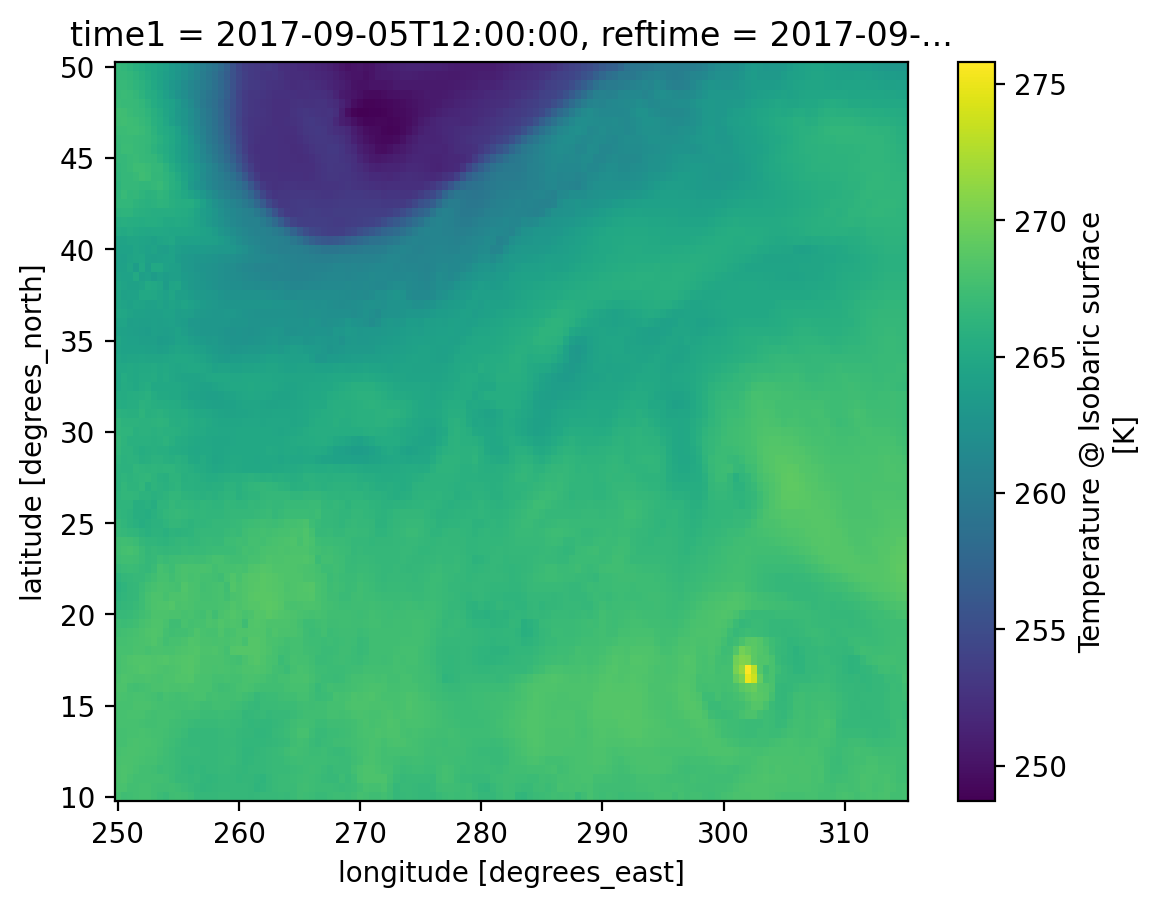

In [12]:
temperature_selection.plot()

Note that we can do likewise with relative humidity, and even chain together the methods in a single line of code:

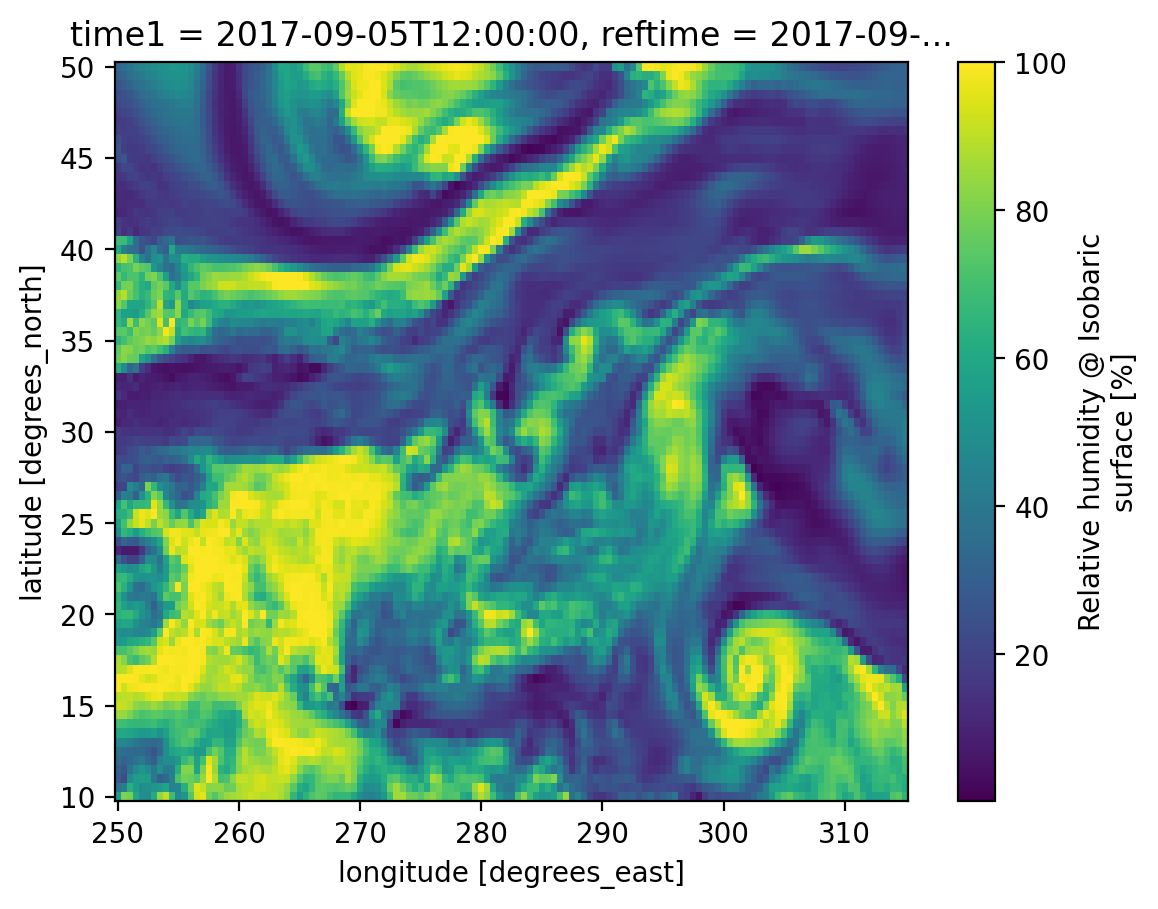

In [13]:
data['Relative_humidity_isobaric'].sel(time1='2017-09-05T12:00', isobaric3=50000).plot()

> Question: here, we've performed the "Examine individual variables" step of EDA. Can you take it further to "Examine relationships among variables" by interpretting multiple plots together?

## Step 4: Exploring Summaries and Calculations

Here, we'll briefly touch on the kind of operations you can perform on an xarray data object that may be helpful for EDA. For a more thourough coverage on the topic, see the [relevant sections of the online xarray tutorial](https://tutorial.xarray.dev/fundamentals/03_computation.html).

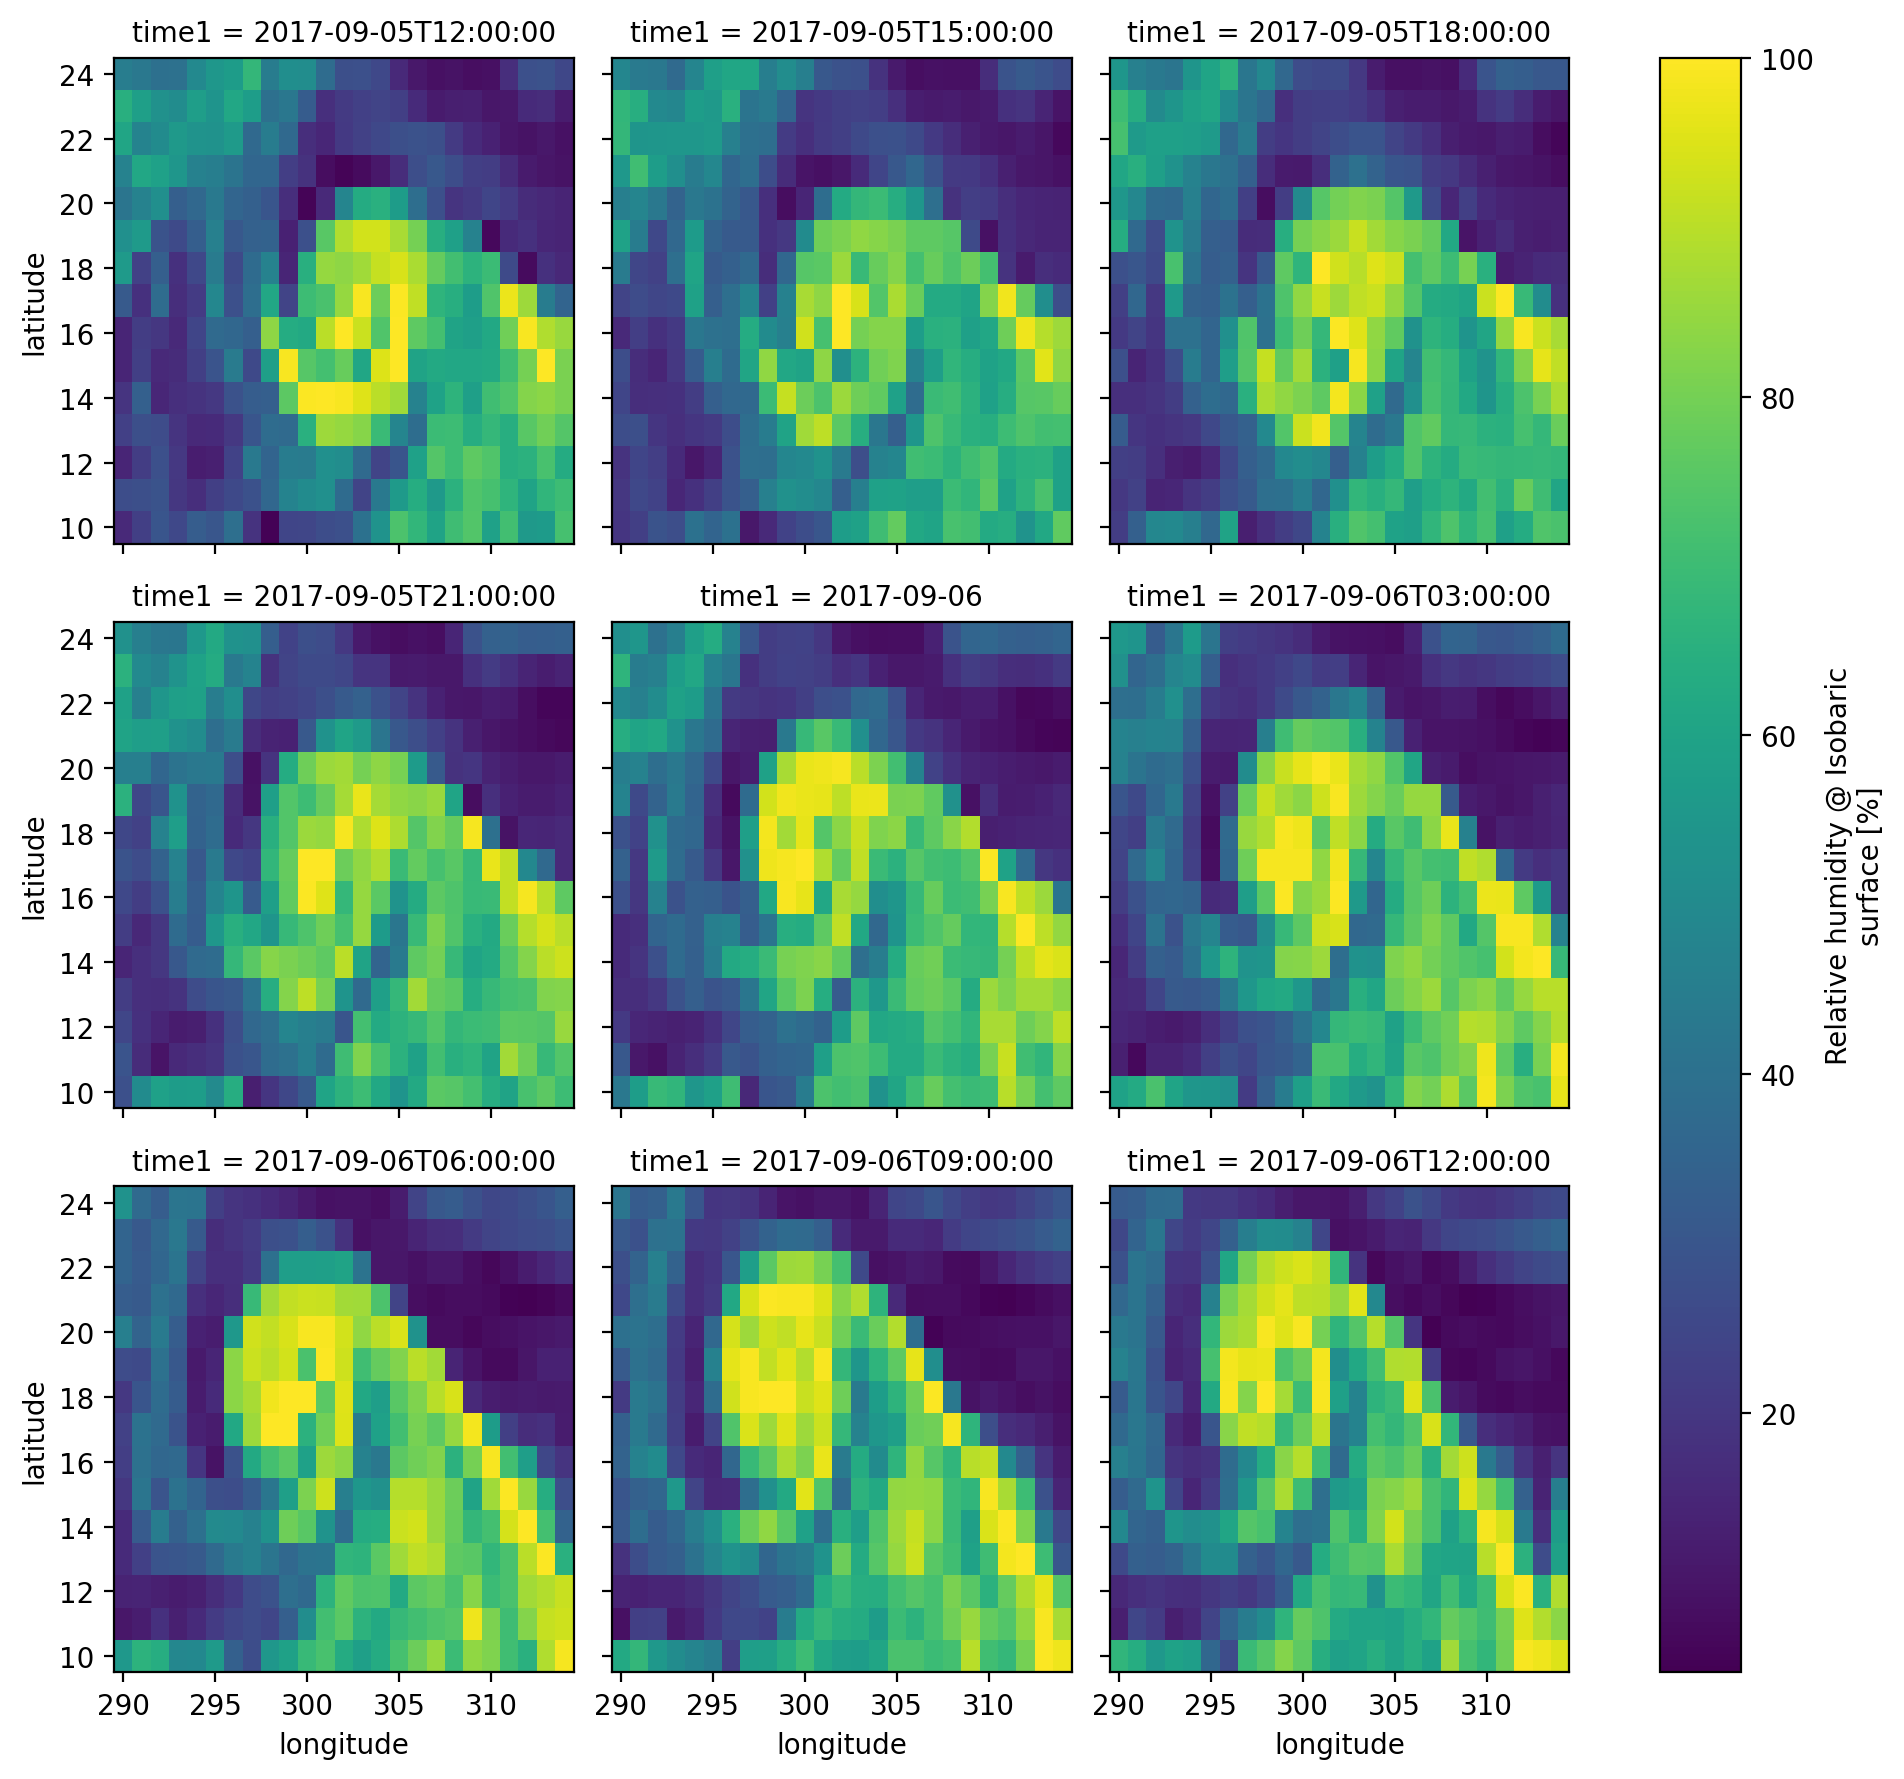

In [14]:
# Let's subset to the corner of the domain that covers the hurricane in it
data_subset = data.sel(latitude=range(10, 25), longitude=range(290, 315))
data_subset['Relative_humidity_isobaric'].sel(isobaric3=50000).plot(col='time1', col_wrap=3)

In [15]:
# What is the minimum 500 hPa geopotential height, at each time?
min_height = data_subset['Geopotential_height_isobaric'].sel(isobaric3=50000).min(('latitude', 'longitude'))
min_height

<xarray.DataArray 'Geopotential_height_isobaric' (time1: 9)>
array([5513.439 , 5631.931 , 5401.116 , 5537.366 , 5467.159 , 5542.069 ,
       5616.064 , 5307.4937, 5519.602 ], dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 2017-09-05T12:00:00 ... 2017-09-06T12:0...
    reftime    datetime64[ns] 2017-09-05T12:00:00
    isobaric3  float64 5e+04

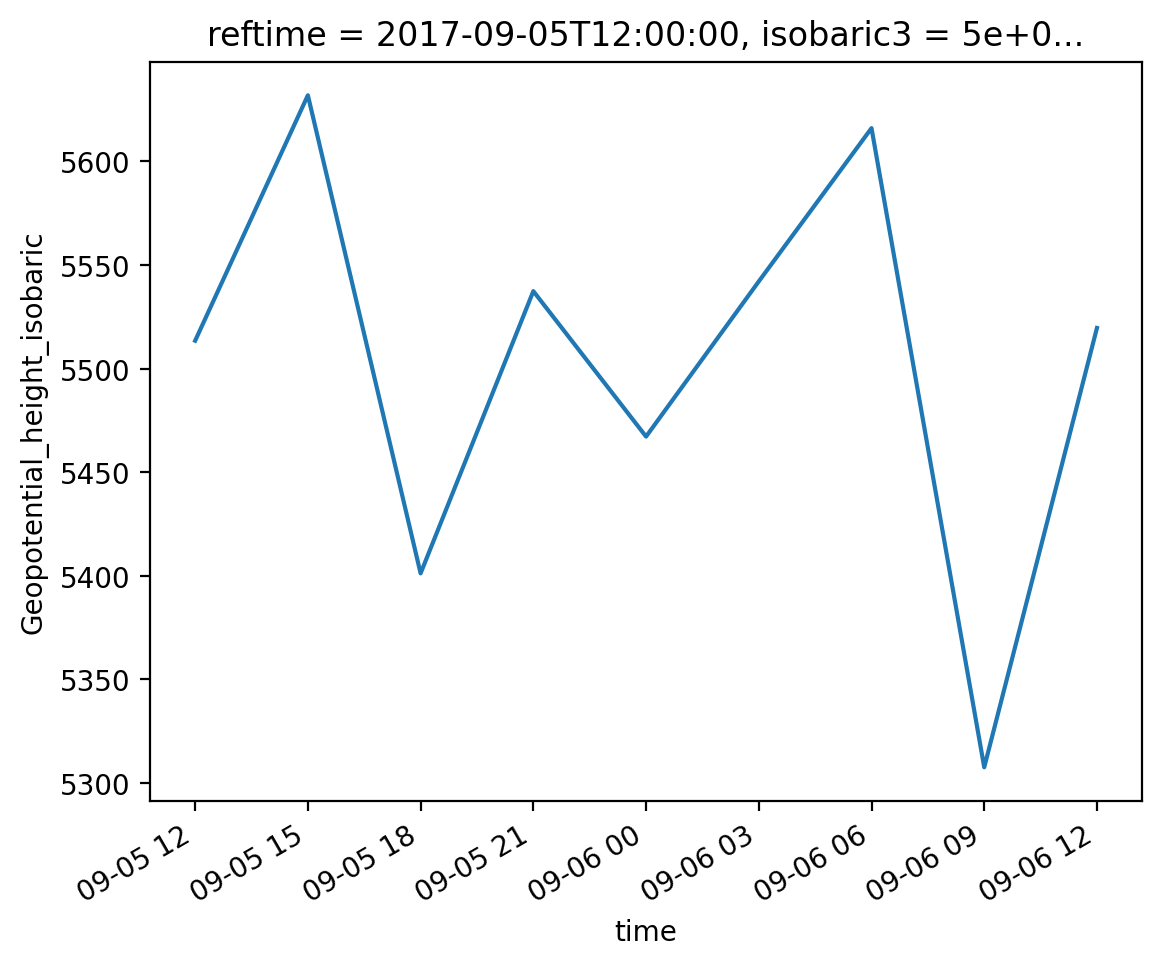

In [16]:
min_height.plot()

Let's break apart what we did here:

- the `['Geopotential_height_isobaric']` selects our data variable from the dataset, as before
- the `.sel(isobaric3=50000)` selects the 50000 Pa (500 hPa) level, as before
- `.min(('latitude', 'longitude'))` computes the minimum (`.min`) across the dimensions of latitude and longitude (the argument to `.min`), leaving time to remain.

> Question: What other calculations/operations might you want to explore? Feel free to explore the [xarray docs](https://docs.xarray.dev/en/stable/user-guide/computation.html#aggregation) or the [MetPy docs](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#calculations) for inspiration (and don't forget to include the imports if you're including a new library we haven't used yet!).

## Step 5: Looking Ahead

There are many, many more features of xarray that are useful for EDA that we don't have the capacity to cover in this session, such as:

- High level computations like groupby, resample, rolling, coarsen, and weighted
- Unit-aware operations with Pint ia pint-xarray or MetPy
- How to wrangle/adapt your metadata when it doesn't already conform to community conventions like CF
- Handling larger-than-memory datasets with dask

The [xarray docs](https://docs.xarray.dev/en/stable/index.html) and [Project Pythia cookbook collection](https://cookbooks.projectpythia.org/) are great jumping-off points for exploring such functionality (and much more)!